In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data download

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68608000/68606236 [==============================] - 7s 0us/step
Found 2000 files belonging to 2 classes.


In [6]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


## Show the first 20 images and labels from the training set:

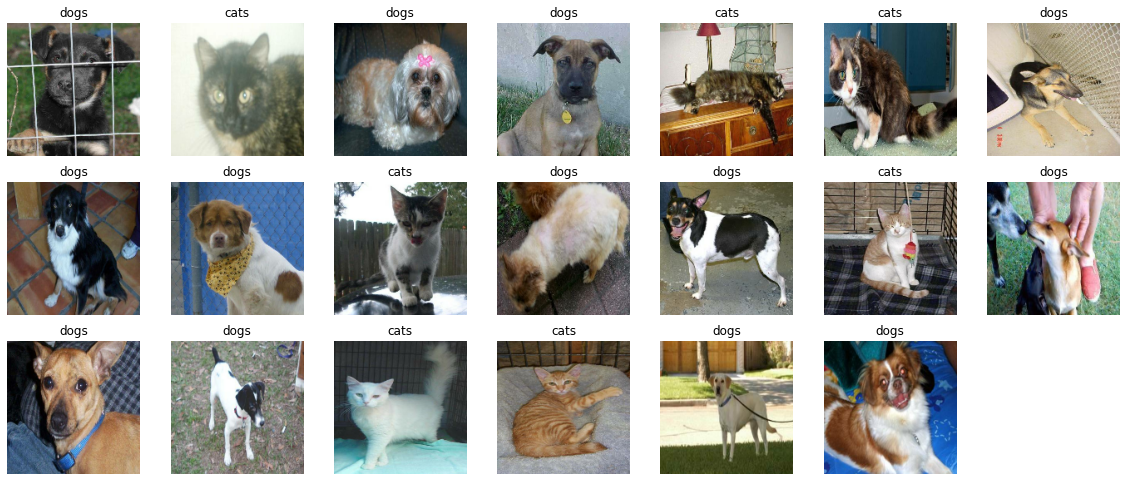

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
  for i in range(20):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Note
As the original dataset doesn't contains a test set, we will create 
one. To do so, determine how many batches of data are available in 
the validation set using tf.data.experimental.cardinality, 
then move 20% of them to a test set

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

## Show the number of test batches and validation batches

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 21
Number of test batches: 5


### Configure the dataset for performance
It is important ? 


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. 

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

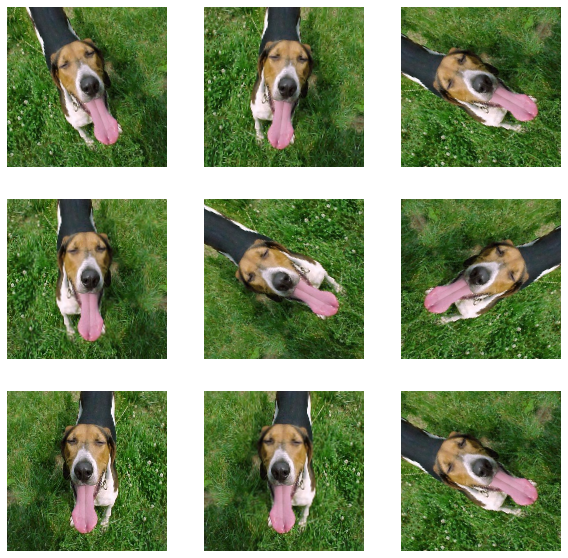

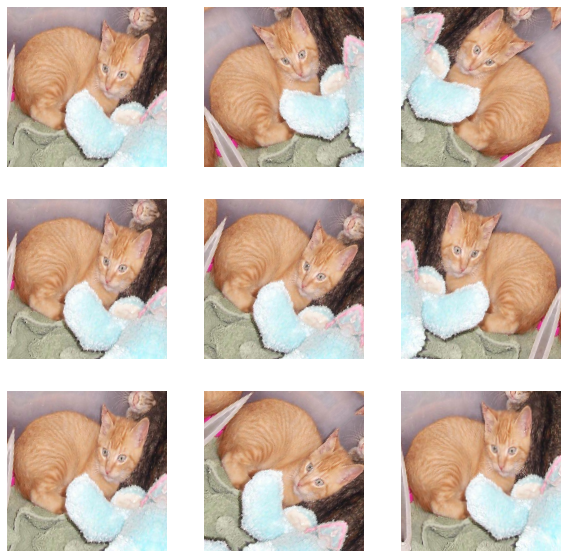

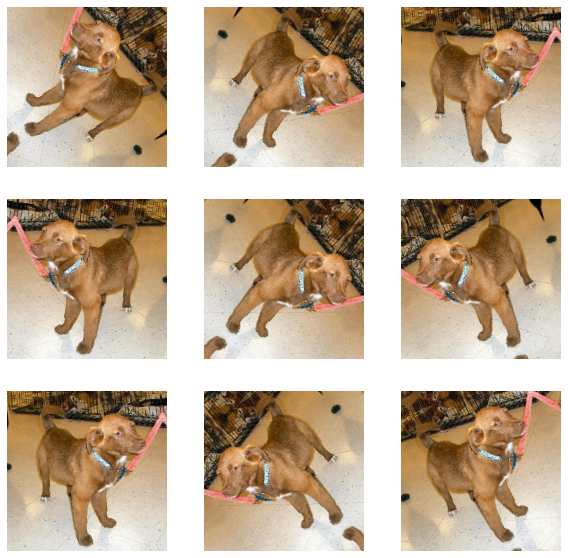

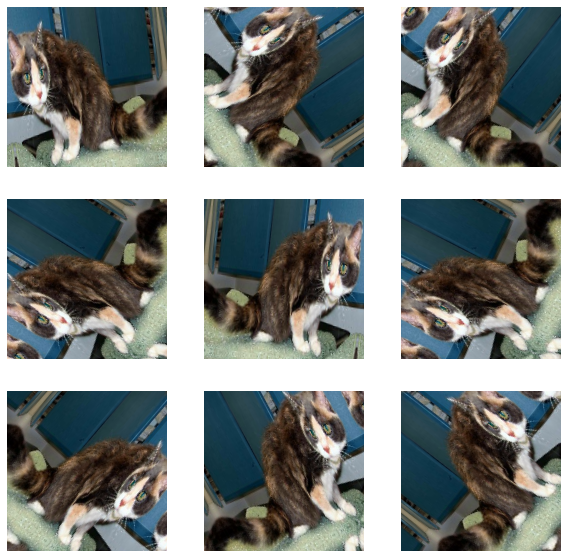

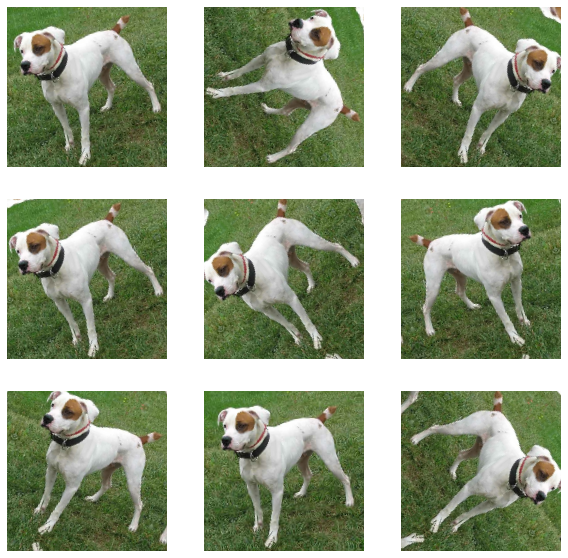

In [18]:
for image, _ in train_dataset.take(5):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## MobileNetV2 model - and resclae pixelvalues
I will download MobileNetV2 for use as our base model. To rescale them, use the preprocessing method included with the model.

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model from the pre-trained convnets
I created the base model from the MobileNetV2 model developed at Google. This is pretrained on the ImageNet dataset. 
ImageNet is a research training dataset. This is includes a wide variety categories like jackFruit. This base of knowledge will help us classify cats and dogs from our specific dataset.

##### NOTE
First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [25]:
## Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top = False,
                                               weights = 'imagenet')

###### This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features

In [27]:
image_batch , label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature extraction and Freeze the convolutional base

### NOTE

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

In [28]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

#### Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


##  Note :
Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0
    

In [32]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [33]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.

In [35]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     


The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [41]:
len(model.trainable_variables)

158

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [46]:
initial_epochs = 5 ## it should be 10

loss0, accuracy0 = model.evaluate(validation_dataset)

21/21 [==============================] - 17s 709ms/step - loss: 0.0631 - accuracy: 0.9799


In [47]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.06
initial accuracy: 0.98


In [48]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
63/63 [==============================] - 161s 3s/step - loss: 0.1325 - accuracy: 0.9370 - val_loss: 0.0625 - val_accuracy: 0.9815
Epoch 2/5
63/63 [==============================] - 160s 3s/step - loss: 0.1395 - accuracy: 0.9410 - val_loss: 0.0422 - val_accuracy: 0.9846
Epoch 3/5
63/63 [==============================] - 157s 2s/step - loss: 0.0786 - accuracy: 0.9690 - val_loss: 0.0466 - val_accuracy: 0.9846
Epoch 4/5
63/63 [==============================] - 155s 2s/step - loss: 0.0713 - accuracy: 0.9755 - val_loss: 0.0880 - val_accuracy: 0.9522
Epoch 5/5
63/63 [==============================] - 163s 3s/step - loss: 0.0915 - accuracy: 0.9620 - val_loss: 0.0532 - val_accuracy: 0.9799


## Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

## Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training

In [49]:
base_model.trainable = True

In [50]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


## Compile the model

### Note
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [51]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [54]:
len(model.trainable_variables)

56

### Continue training the model

In [56]:
fine_tune_epochs = 5 ##it should be 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
63/63 [==============================] - 88s 1s/step - loss: 0.0401 - accuracy: 0.9865 - val_loss: 0.0410 - val_accuracy: 0.9861
Epoch 6/10
63/63 [==============================] - 83s 1s/step - loss: 0.0307 - accuracy: 0.9885 - val_loss: 0.0550 - val_accuracy: 0.9830
Epoch 7/10
63/63 [==============================] - 81s 1s/step - loss: 0.0265 - accuracy: 0.9910 - val_loss: 0.0318 - val_accuracy: 0.9846
Epoch 8/10
63/63 [==============================] - 80s 1s/step - loss: 0.0237 - accuracy: 0.9880 - val_loss: 0.0268 - val_accuracy: 0.9892
Epoch 9/10
63/63 [==============================] - 90s 1s/step - loss: 0.0297 - accuracy: 0.9890 - val_loss: 0.0416 - val_accuracy: 0.9846
Epoch 10/10
63/63 [==============================] - 102s 2s/step - loss: 0.0193 - accuracy: 0.9920 - val_loss: 0.0511 - val_accuracy: 0.9861


### Note
Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.

After fine tuning the model nearly reaches 98% accuracy on the validation set.

## Evaluation and prediction

Finaly we can verify the performance of the model on new data using test set.

In [57]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 8s 1s/step - loss: 0.0396 - accuracy: 0.9812
Test accuracy : 0.981249988079071


## !!!  And now we are all set to use this model to predict if our pet is a cat or dog.

Predictions:
 [1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0]
Labels:
 [1 1 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0]


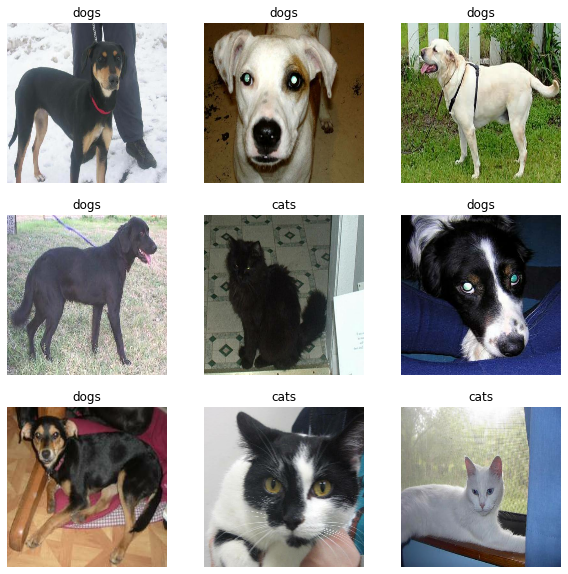

In [58]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Summary

Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.


Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.
